In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataval.dataset import WeatherDataset
from dataval.train import CatBoostTrainer

import os
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from wandb.integration.catboost import WandbCallback

os.environ["WANDB_QUIET"] = "true" # Let's keep the output clean

# Let's start a new W&B run to track our work
run = wandb.init(project="ml-dataval-tutorial")

# Training Pipelines

In this notebook, we load the weather dataset (described in https://arxiv.org/pdf/2107.07455.pdf). We split the dataset into weekly partitions. Then we create 2 pipelines: one that trains a model on the first week & deploys on all following weeks, and another that continually trains & deploys on each consecutive pair of weeks.

In [3]:
# Load dataset

ds = WeatherDataset(os.path.join(os.getcwd(), "canonical-partitioned-dataset"), sample_frac=0.2)

## Train-Once

We use a catboost model, optimizing for RMSE of weather prediction. We use off-the-shelf models/parameters (no ensembling or uncertainty estimation to keep things simple).

In [4]:
first_iter = True
test_mses = {}
train_mse = None

for train_df, test_df in ds.iterate():
    X_train, y_train = ds.split_feature_label(train_df)
    
    if first_iter:
        catboost_hparams = {"depth": 5, "iterations": 250, "learning_rate": 0.03, "loss_function": "RMSE"}
        # Let's log the hyperparameters to W&B
        wandb.config.update(catboost_hparams)
        t = CatBoostTrainer(catboost_hparams)
        print(f"Training for {ds.get_partition_key(train_df)}...")
        # We'll pass in the W&B callback to log metrics
        t.fit(X_train, y_train, verbose=100, callbacks=[WandbCallback()])
        first_iter = False

        train_mse = t.score(X_train, y_train)
    
    # Evaluate
    X_test, y_test = ds.split_feature_label(test_df)
    test_mses[ds.get_partition_key(test_df)] = t.score(X_test, y_test)

Training for 2018_35...
0:	learn: 6.8630900	test: 6.5818422	best: 6.5818422 (0)	total: 59.7ms	remaining: 14.9s
100:	learn: 2.2650862	test: 2.3107749	best: 2.3107749 (100)	total: 318ms	remaining: 469ms
200:	learn: 2.0363098	test: 2.2171372	best: 2.2171372 (200)	total: 580ms	remaining: 141ms
249:	learn: 1.9722278	test: 2.1944450	best: 2.1944450 (249)	total: 713ms	remaining: 0us

bestTest = 2.194445003
bestIteration = 249



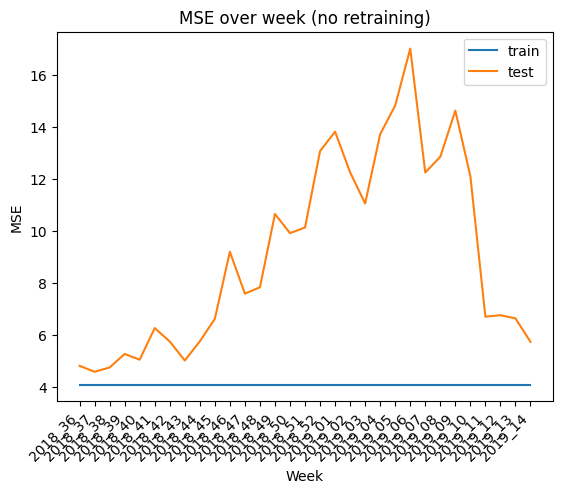

In [5]:
plt.plot(test_mses.keys(), [train_mse] * len(test_mses.keys()), label="train")
plt.plot(test_mses.keys(), test_mses.values(), label="test")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Week")
plt.ylabel("MSE")
plt.title("MSE over week (no retraining)")
plt.legend()
# Let's log our plot to W&B so that we can refer to it in reports and dashboards
wandb.log({"MSE over week (no retraining)": wandb.Image(plt)})
plt.show()

Wow, it looks like the MSE gets significantly worse as we deploy over time! Makes sense, as the seasons change.

## Continual-Train

In [6]:
test_mses = {}
train_mses = {}

for train_df, test_df in ds.iterate():
    X_train, y_train = ds.split_feature_label(train_df)
    
    catboost_hparams = {"depth": 5, "iterations": 250, "learning_rate": 0.03, "loss_function": "RMSE"}
    continual_t = CatBoostTrainer(catboost_hparams)
    continual_t.fit(X_train, y_train, verbose=False)
    train_mses[ds.get_partition_key(train_df)] = continual_t.score(X_train, y_train)
    
    # Evaluate
    X_test, y_test = ds.split_feature_label(test_df)
    test_mses[ds.get_partition_key(test_df)] = continual_t.score(X_test, y_test)

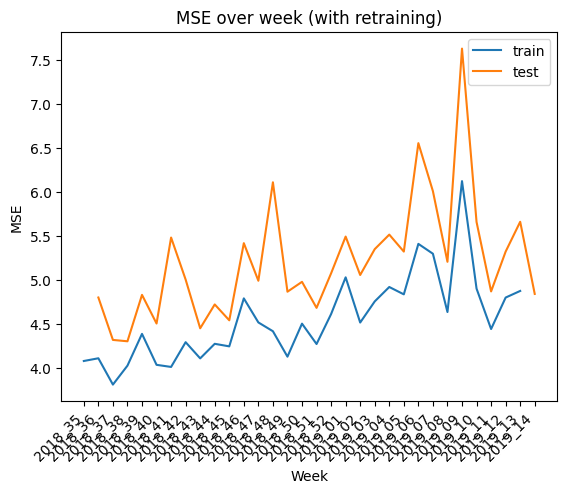

In [7]:
plt.plot(train_mses.keys(), train_mses.values(), label="train")
plt.plot(test_mses.keys(), test_mses.values(), label="test")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Week")
plt.ylabel("MSE")
plt.title("MSE over week (with retraining)")
plt.legend()
# Let's log our plot to W&B so that we can refer to it in reports and dashboards
wandb.log({"MSE over week (with retraining)": wandb.Image(plt)})
plt.show()

The MSEs improve here, because we're retraining on fresh data.

In [8]:
continual_t.get_feature_importance().head(25)

,feature,importance
6,cmc_0_0_0_2_interpolated,22.321365
89,gfs_temperature_sea_interpolated,15.095626
99,wrf_t2,11.442965
109,wrf_t2_interpolated,11.176995
8,cmc_0_0_0_2,8.895680
100,wrf_t2_next,8.157100
87,gfs_temperature_sea,5.164831
7,cmc_0_0_0_2_next,3.692906
90,gfs_temperature_sea_next,1.909396
1,sun_elevation,1.583235


In [9]:
# We can finish now the W&B run
run.finish()